#### **Transformer Architecture**

The Transformer model, built solely on the self-attention mechanism, is a deep architecture that enables parallel computation and has the shortest maximum path length.

Originally designed for sequence-to-sequence tasks on text, Transformers are now widely used in language, vision, speech, and reinforcement learning.

The Encoder-Decoder Transformer architecture uses self-attention in both the encoder and decoder modules. Unlike other attention models like Bahdanau attention, the Transformer applies positional encoding to the input and output sequence embeddings before they are processed by the stacked self-attention layers.

**Transformer Encoder**

The Transformer encoder consists of a stack of identical layers. Each layer has two sublayers: a multi-head self-attention mechanism and a position-wise feed-forward network.

For each sublayer, a residual connection and layer normalization are applied. The output of a sublayer with input x is:

LayerNorm(x+Sublayer(x))
In the encoder, the queries, keys, and values for the self-attention sublayer are all derived from the output of the previous encoder layer. The final output of the transformer is a sequence of d-dimensional vector representations, one for each input token.

**Transformer Decoder**

The Transformer decoder is a stack of layers with residual connections and layer normalizations. Each layer contains three sublayers: a masked multi-head self-attention layer, an encoder-decoder attention layer, and a position-wise feed-forward network.

**Masked Self-Attention**: The decoder's self-attention is "masked" to ensure that predictions for a given position only depend on previously generated output tokens. This preserves the auto-regressive property, which means each position in the decoder can only attend to positions up to itself.

**Encoder-Decoder Attention**: This sublayer receives queries from the output of the masked self-attention sublayer. However, its keys and values come from the final output of the encoder stack. This allows the decoder to attend to all positions in the input sequence.

**Positionwise Feed-Forward Networks**

The position-wise feed-forward network uses a two-layer MLP to transform the representation of each position in a sequence independently and identically. The input tensor X with shape (B,T,D) is transformed into an output tensor with shape (B,T,D
f
​
 ).

In [ ]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_hiddens, ffn_num_outputs):
        super().__init__()
        self.dense1 = nn.LazyLinear(ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.LazyLinear(ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

**Residual Connection and Layer Normalization**

Add & Norm is a residual connection immediately followed by the layer normalization.  Both are key to the deep architectures.

Batch normalization recenters and rescales across the samples within a minibatch. Layer normalization is the same as batch normalization except that the formal normalizes across the feature dimension, enjoying the benefits of scale independence and batch size independence.

Despite its pervasive applications in computer vision, batch normalization is less effective than layer normalization in LLMs (whose inputs are variable length sequences).

AddNorm with a residual connection and Dropout
- The residual connection requires that the two input are of the same shape so that the tensor also has the same shape after the addition operation.

In [ ]:
class AddNorm(nn.Module):
    def __init__(self, norm_shape, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(norm_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

Classes and Abstractions

In [ ]:
''' The Base Encoder interface for the Enc-Dec architecture '''
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, X, *args):
    raise NotImplementedError

''' The Base Decoder interface for the Enc-Dec architecture '''
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()

  # there can be additional arguments (such as length excluding padding)
  def init_state(self, enc_all_outputs, *args):
    raise NotImplementedError

  def forward(self, X, *args):
    raise NotImplementedError

In [ ]:
class PositionalEncoding(nn.Module):
  def __init__(self, num_hiddens, dropout, max_len=1000):
      super().__init__()
      self.dropout = nn.Dropout(dropout)
      self.P = torch.zeros((1, max_len, num_hiddens))
      X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32)/num_hiddens)
      self.P[:, :, 0::2] = torch.sin(X)
      self.P[:, :, 1::2] = torch.cos(X)

  def forward(self, X):
    X = X + self.P[:, :X.shape[1], :].to(X.device)
    return self.dropout(X)

In [ ]:
class MultiHeadAttention(Module):
  def __init__(
      self, num_hiddens, num_heads, dropout, bias=False, **kwargs):
    super().__init__()
    self.num_heads = num_heads
    self.attention = DotProductAttention(dropout)
    self.W_q = nn.LazyLinear(num_hiddens, bias=bias)
    self.W_k = nn.LazyLinear(num_hiddens, bias=bias)
    self.W_v = nn.LazyLinear(num_hiddens, bias=bias)
    self.W_o = nn.LazyLinear(num_hiddens, bias=bias)

  def transpose_qkv(self, X):
    X = X.reshape(X.shape[0], X.shape[1], self.num_heads, -1)
    X = X.permute(0, 2, 1, 3)
    return X.reshape(-1, X.shape[2], X.shape[3])

  def transpose_output(self, X):
    X = X.reshape(-1, self.num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

  def forward(self, queries, keys, values, valid_lens):
    queries = self.transpose_qkv(self.W_q(queries))
    keys = self.transpose_qkv(self.W_k(keys))
    values = self.transpose_qkv(self.W_v(values))

    if valid_lens is not None:
      valid_lens = torch.repeat_interleave(
          valid_lens, repeats=self.num_heads, dim=0)
    output = self.attention(queries, keys, values, valid_lens)
    output_concat = self.transpose_output(output)
    return self.W_o(output_concat)

In [ ]:
''' The base class attention based decoder interface '''
class AttentionDecoder(Decoder):
  def __init__(self):
    super().__init__()

  @property
  def attention_weights(self):
    raise NotImplementedError

**Transformer Encoder Implementation**

In [ ]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                 use_bias=False):
        super().__init__()
        self.attention = MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(num_hiddens, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

class TransformerEncoder(Encoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                 num_heads, num_blks, dropout, use_bias=False):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block" + str(i), TransformerEncoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

    def forward(self, X, valid_lens):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

**Transformer Decoder Implementation**

In [ ]:
class TransformerDecoderBlock(nn.Module):
    ''' the i-th block in the Transformer decoder '''
    def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
        super().__init__()
        self.i = i
        self.attention1 = MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm1 = AddNorm(num_hiddens, dropout)
        self.attention2 = MultiHeadAttention(num_hiddens, num_heads,
                                                 dropout)
        self.addnorm2 = AddNorm(num_hiddens, dropout)
        self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(num_hiddens, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), dim=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [ ]:
class TransformerDecoder(AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    @property
    def attention_weights(self):
        return self._attention_weights

In [ ]:
''' Dot-product attention & dropout for regularization '''
class DotProductAttention(nn.Module):
  def __init__(self, dropout):
    super().__init__()
    self.dropout = nn.Dropout(dropout)

  def forward(self, queries, keys, values, valid_lens=None):
    d = queries.shape[-1]
    scores = torch.bmm(queries, keys.transpose(1, 2)) /math.sqrt(d)
    self.attention_weights = masked_softmax(scores, valid_lens)
    return torch.bmm(self.dropout(self.attention_weights), values)

**Training**

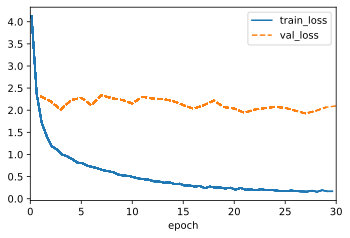

In [ ]:
''' Train Encoder-Decoder Model
Transformer encoder decoder have 2-layers using 4-head attention. '''
data = MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 256, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
trainer = Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [ ]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), gpus[0], data.num_steps)

for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['il', 'est', 'calme', '.'], bleu,1.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


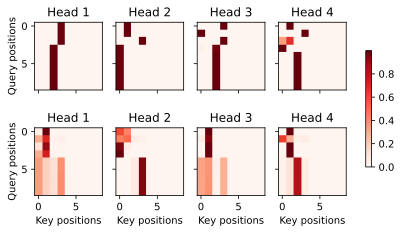

In [ ]:
''' Visualize the Transformer attention weights
The shape of the encoder self-attention weights is number of encoder layers, number of attention heads, num_steps or number of queries, num_steps or number of key-value pairs. '''
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), gpus[0], data.num_steps, True)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)
shape = (num_blks, num_heads, -1, data.num_steps)
enc_attention_weights = enc_attention_weights.reshape(shape)
check_shape(enc_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

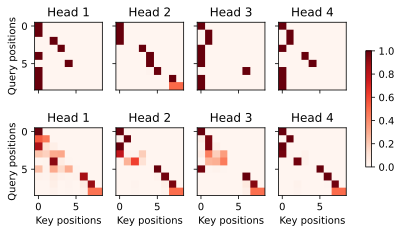

In [ ]:
''' To visualize both decoder self-attention weights and the encoder-decoder attentionweights we perform more data manipulations. We fill the masked attention weights with zero. The decoder self-attention weights and the encoder-decoder attention weights have both the same queries. '''
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weights
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
shape = (-1, 2, num_blks, num_heads, data.num_steps)
dec_attention_weights = dec_attention_weights_filled.reshape(shape)
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)

check_shape(dec_self_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))
check_shape(dec_inter_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))

''' Due to the auto-regressive property of the decoder self-attention, no query attends to key-value pairs after the query position '''
show_heatmaps(
    dec_self_attention_weights[:, :, :, :],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

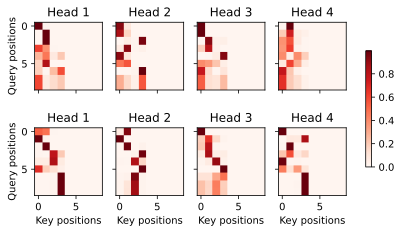

In [ ]:
''' Similar to the encoder self-attention, no query from the output sequence attends to those padding tokens from the input sequence '''
show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

The Transformer is an encoder-decoder architecture, but you can also use the encoder or decoder on its own. In the Transformer, **multi-head self-attention** is used to represent the input and output sequences. The decoder uses a **masked** version of this attention to maintain its auto-regressive property. To enable the training of a deep model, the Transformer incorporates **residual connections** and **layer normalization**. Finally, a **position-wise feed-forward network transforms **the representation at each sequence position using the same multi-layer perceptron.